In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [0]:
base_path = './drive/My Drive/Colab Notebooks/Speech Denoising/Data/'

In [4]:
!pip install librosa

In [0]:
import librosa

In [0]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [0]:
s, sr=librosa.load(base_path + 'train_clean_male.wav', sr=None)
train_clean=librosa.stft(s, n_fft=1024, hop_length=512).T

sn, sr=librosa.load(base_path + 'train_dirty_male.wav', sr=None)
train_dirty=librosa.stft(sn, n_fft=1024, hop_length=512).T

In [9]:
train_clean.shape, train_dirty.shape

((2459, 513), (2459, 513))

### Take magnitudes of audio signals

In [0]:
train_clean_val = np.abs(train_clean)
train_dirty_val = np.abs(train_dirty)

Check bounds of absolute values

In [11]:
print(f'min(train_clean_val) = {np.min(train_clean_val)}, max(train_clean_val) = {np.max(train_clean_val)}')
print(f'min(train_dirty_val) = {np.min(train_dirty_val)}, max(train_dirty_val) = {np.max(train_dirty_val)}')

min(train_clean_val) = 2.724569583278935e-07, max(train_clean_val) = 31.574600219726562
min(train_dirty_val) = 3.297913409028297e-08, max(train_dirty_val) = 31.603910446166992


## Training

### Split the data into training and validation set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_dirty_val, train_clean_val, test_size=0.2)

### Define tensorflow variables for the model

In [0]:
X = tf.placeholder(dtype='float', shape=[None, 513])
y = tf.placeholder(dtype='float', shape=[None, 513])

#### Network architecture. 

Since, we are trying to remove the noise, the following architecture makes the most sense. The network is narrow in the middle, so it has to get rid of some singals, but still be able to construct desired clean audio. This means the network must be getting rid of all non-essential signals i.e. noise, leaving us with clean audio.

In [0]:
in_units = 513
h1_units = 380
h2_units = 200
h3_units = 200
h4_units = 380
out_units = 513

#### Initialize weight and bias matrix using He initializer


In [15]:
# He initializer: mean = 0.0, stddev = sqrt(2/#in_nodes)
weights = {
    'w1': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[in_units, h1_units], mean=0.0, stddev=np.sqrt(2/in_units))),
    'w2': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h1_units, h2_units], mean=0.0, stddev=np.sqrt(2/h1_units))),
    'w3': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h2_units, h3_units], mean=0.0, stddev=np.sqrt(2/h2_units))),
    'w4': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h3_units, h4_units], mean=0.0, stddev=np.sqrt(2/h3_units))),
    'out': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h4_units, out_units], mean=0.0, stddev=np.sqrt(2/h4_units))),
}

bias_initial_value = 0.01
biases = {
    'b1': tf.Variable(initial_value=tf.ones([h1_units]) * bias_initial_value),
    'b2': tf.Variable(initial_value=tf.ones([h2_units]) * bias_initial_value),
    'b3': tf.Variable(initial_value=tf.ones([h3_units]) * bias_initial_value),
    'b4': tf.Variable(initial_value=tf.ones([h4_units]) * bias_initial_value),
    'out': tf.Variable(initial_value=tf.ones([out_units]) * bias_initial_value)
}

Instructions for updating:
Colocations handled automatically by placer.


#### Plug everything together

In [16]:
# hyper-parameters
beta = 0.000005
learning_rate = 0.0001

z1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
a1 = tf.nn.relu(z1)

z2 = tf.add(tf.matmul(a1, weights['w2']), biases['b2'])
a2 = tf.nn.relu(z2)

z3 = tf.add(tf.matmul(a2, weights['w3']), biases['b3'])
a3 = tf.nn.relu(z3)

z4 = tf.add(tf.matmul(a2, weights['w4']), biases['b4'])
a4 = tf.nn.relu(z4)

logits = tf.add(tf.matmul(a4, weights['out']), biases['out'])
output = tf.nn.relu(logits)

# losses
regularizers = tf.nn.l2_loss(weights['w1']) + tf.nn.l2_loss(weights['w2']) + tf.nn.l2_loss(weights['w3']) + tf.nn.l2_loss(weights['w4']) + tf.nn.l2_loss(weights['out'])
mse = tf.losses.mean_squared_error(labels=y, predictions=output)
loss = tf.reduce_mean(mse + beta * regularizers)

train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=loss)

init = tf.global_variables_initializer()

Instructions for updating:
Use tf.cast instead.


In [17]:
batch_size = 1000
num_epochs = 10000
display_step = 1000
log_step = 10

total_samples = X_train.shape[0]
num_batches = int(math.ceil(total_samples/batch_size))

# these lists will be used to display accuracy/loss graphs over epochs
train_loss, test_loss = [], []
train_mse, test_mse = [], []

sess = tf.Session()

sess.run(init)
for epoch in range(1, num_epochs + 1):
  for itr in range(num_batches):
    start_idx = itr * batch_size
    end_idx = min((itr + 1) * batch_size, total_samples)
    batch_x, batch_y = X_train[start_idx:end_idx, :], y_train[start_idx:end_idx, :]
    sess.run(train, feed_dict={X: batch_x, y: batch_y})
    
  if epoch % log_step == 0:
    trls, trmse = sess.run([loss, mse], feed_dict={X: X_train, y: y_train})
    tsls, tsmse = sess.run([loss, mse], feed_dict={X: X_test, y: y_test})
    
    train_loss.append(trls)
    train_mse.append(trmse)
    
    test_loss.append(tsls)
    test_mse.append(tsmse)
    
  if epoch % display_step == 0:
    print(f'Epoch:{epoch}')
    print(f'Train set:\tLoss:{trls:.4f},\tMSE:{trmse:.4f}')
    print(f'Test set:\tLoss:{tsls:.4f},\tMSE:{tsmse:.4f}\n')

Epoch:1000
Train set:	Loss:0.0092,	MSE:0.0039
Test set:	Loss:0.0160,	MSE:0.0107

Epoch:2000
Train set:	Loss:0.0057,	MSE:0.0021
Test set:	Loss:0.0117,	MSE:0.0081

Epoch:3000
Train set:	Loss:0.0037,	MSE:0.0012
Test set:	Loss:0.0088,	MSE:0.0064

Epoch:4000
Train set:	Loss:0.0028,	MSE:0.0010
Test set:	Loss:0.0076,	MSE:0.0058

Epoch:5000
Train set:	Loss:0.0024,	MSE:0.0008
Test set:	Loss:0.0070,	MSE:0.0055

Epoch:6000
Train set:	Loss:0.0022,	MSE:0.0007
Test set:	Loss:0.0068,	MSE:0.0054

Epoch:7000
Train set:	Loss:0.0021,	MSE:0.0007
Test set:	Loss:0.0067,	MSE:0.0053

Epoch:8000
Train set:	Loss:0.0021,	MSE:0.0007
Test set:	Loss:0.0066,	MSE:0.0052

Epoch:9000
Train set:	Loss:0.0020,	MSE:0.0007
Test set:	Loss:0.0065,	MSE:0.0052

Epoch:10000
Train set:	Loss:0.0020,	MSE:0.0007
Test set:	Loss:0.0065,	MSE:0.0052



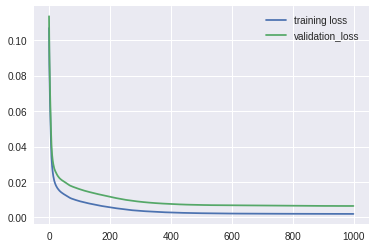

In [18]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['training loss', 'validation_loss'])

## Testing

### Calculate Signal-to-Noise Ratio using following formula

<img src="https://d1b10bmlvqabco.cloudfront.net/attach/jqcgj7tyoxz6oi/jl5gazm4ih22q1/jrx4uo8px5hd/SNR.JPG" width="400">


In [0]:
def snr(dirty, clean):
  return 10 * np.log10(np.sum(np.square(clean))/np.sum(np.square(clean - dirty)))

#### SNR for training data

In [20]:
cleaned = sess.run(output, feed_dict={X: X_train})
print(snr(cleaned, y_train))

21.62442684173584


#### SNR for validation data

In [21]:
cleaned = sess.run(output, feed_dict={X: X_test})
print(snr(cleaned, y_test))

13.031316995620728


## Prediction

In [0]:
def clean_audio(filename):
    # load audio file
    s, sr = librosa.load(filename, sr=None)
    
    # apply short time fourier transform
    dirty = librosa.stft(s, n_fft=1024, hop_length=512).T
    
    # take magnitudes of audio signals
    dirty_val = np.abs(dirty)
    
    # run it through the neural network to remove noisy bits
    clean_val = sess.run(output, feed_dict={X: dirty_val})
    
    # recover speech spectogram of the cleaned signal
    cleaned = np.multiply(np.divide(dirty.T, dirty_val.T), clean_val.T)
    return cleaned

In [0]:
def save_audio(cleaned, to_filename):
    # recover time domain speech signal by applying inverse short time fourier transform
    sh_test = librosa.istft(cleaned, hop_length=512)
    
    # Save to a file
    librosa.output.write_wav(to_filename, sh_test, sr)
    print('Saved to ', to_filename)

In [24]:
cleaned = clean_audio(base_path + 'test_x_01.wav')
save_audio(cleaned, base_path + 'test_x_01_cleaned.wav')

Saved to  ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_01_cleaned.wav


In [25]:
cleaned = clean_audio(base_path + 'test_x_02.wav')
save_audio(cleaned, base_path + 'test_x_02_cleaned.wav')

Saved to  ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_02_cleaned.wav


In [0]:
sess.close()